In [1]:
# Common imports
import os
import sys
from tqdm import tqdm
import numpy as np
from pathlib import Path
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import yaml

# Torch imports
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Albumentations for data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Ultralytics YOLO for loading YOLOv11
!pip install ultralytics
from ultralytics import YOLO

In [3]:
#Define the Dataset Class for IP102
class IP102Dataset(Dataset):
    """A dataset class for the IP102 dataset in YOLO format."""

    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with images and labels (e.g., /kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train).
            transform (callable, optional): Optional data augmentation to be applied on a sample.
        """
        self.data_dir = Path(data_dir)
        self.image_list = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = str(self.data_dir / img_name)
        label_path = str(self.data_dir.parent.parent / 'labels' / self.data_dir.name / (img_name.replace('.jpg', '.txt')))

        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Load labels
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                boxes = [list(map(float, line.strip().split())) for line in f.readlines()]
        else:
            boxes = []

        # Parse boxes
        bboxes = []
        labels = []
        for box in boxes:
            class_id, center_x, center_y, width, height = box
            # Convert YOLO format (normalized) to Pascal VOC format (absolute coordinates)
            img_height, img_width = img.shape[:2]
            xmin = (center_x - width / 2) * img_width
            ymin = (center_y - height / 2) * img_height
            xmax = (center_x + width / 2) * img_width
            ymax = (center_y + height / 2) * img_height
            bboxes.append([xmin, ymin, xmax, ymax])
            labels.append(int(class_id))

        if self.transform:
            transformed = self.transform(image=img, bboxes=bboxes, class_labels=labels)
            img = transformed["image"]
            bboxes = transformed["bboxes"]
            labels = transformed["class_labels"]

        if len(bboxes) > 0:
            bboxes = torch.tensor(bboxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.long)
        else:
            bboxes = torch.zeros((0, 4))
            labels = torch.zeros((0,), dtype=torch.long)

        return img, bboxes, labels

In [4]:
# Define Data Augmentation
transform = A.Compose([
    A.LongestMaxSize(416, p=1),
    A.PadIfNeeded(min_height=416, min_width=416, p=1, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_area=20))

/tmp/ipykernel_143/3553826755.py:4: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=416, min_width=416, p=1, border_mode=cv2.BORDER_CONSTANT, value=0),


In [5]:
# Set Up the Dataset and DataLoader
train_data_dir = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train"
val_data_dir = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/val"

train_dataset = IP102Dataset(train_data_dir, transform=transform)
val_dataset = IP102Dataset(val_data_dir, transform=transform)

def collate_fn(batch):
    images, bboxes, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, bboxes, labels

train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

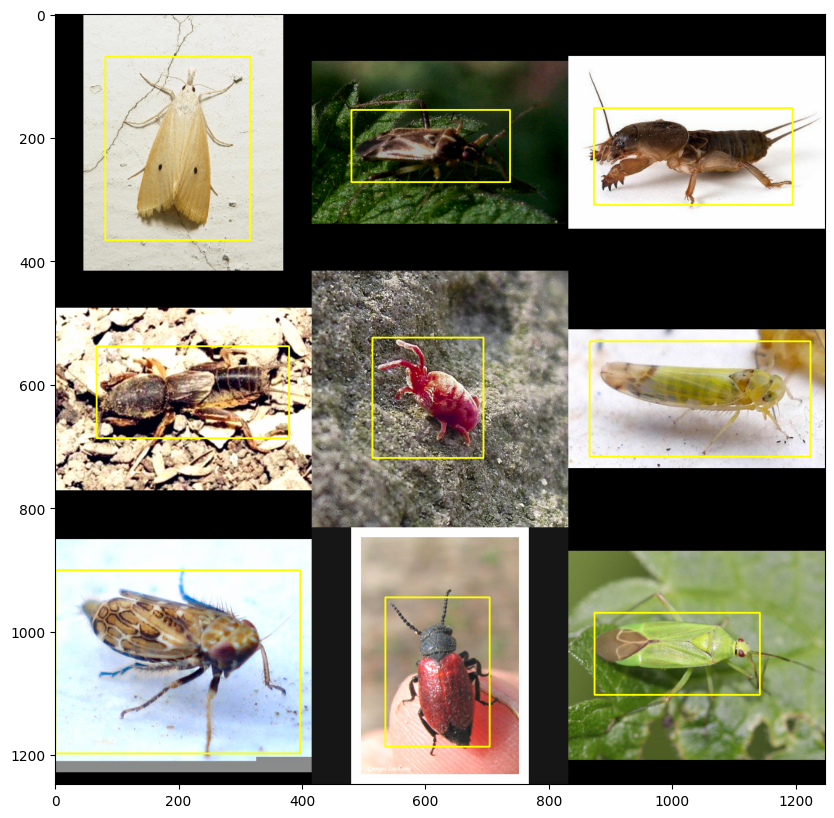

In [6]:
# Sanity Check of the Dataset
hlines = []
for i in range(3):
    vlines = []
    for j in range(3):
        idx = random.randint(0, len(train_dataset) - 1)
        img, bboxes, labels = train_dataset[idx]
        img = img.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = (img * 255).astype(np.uint8)

        for bbox in bboxes:
            x1, y1, x2, y2 = map(int, bbox)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 0), 2)

        vlines.append(img)
    hlines.append(cv2.vconcat(vlines))

final_img = cv2.hconcat(hlines)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(final_img)
plt.show()

In [7]:
# Load Pre-trained YOLOv11 Model
model = YOLO("/kaggle/input/yolo11/pytorch/default/1/yolo11s.pt")

In [8]:
# Copy the original ip102.yaml to the working directory and modify the paths
original_yaml_path = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/ip102.yaml"
new_yaml_path = "/kaggle/working/ip102_corrected.yaml"

# Read the original YAML file
with open(original_yaml_path, 'r') as f:
    yaml_content = yaml.safe_load(f)

# Update the paths to the correct absolute paths
yaml_content['train'] = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train"
yaml_content['val'] = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/val"

# Save the modified YAML file
with open(new_yaml_path, 'w') as f:
    yaml.dump(yaml_content, f)

print(f"Modified ip102.yaml saved to {new_yaml_path}")
print("Updated paths:")
print(f"train: {yaml_content['train']}")
print(f"val: {yaml_content['val']}")

Modified ip102.yaml saved to /kaggle/working/ip102_corrected.yaml
Updated paths:
train: /kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train
val: /kaggle/input/ip102-yolov5/IP102_YOLOv5/images/val


In [9]:
# Train the Model Using Ultralytics YOLO API
# The Ultralytics YOLO implementation simplifies training by handling the loss function and training loop internally.
# We just need to provide the dataset configuration and training parameters.

# Train the model
results = model.train(
    data=new_yaml_path,
    epochs=5,
    imgsz=416,
    batch=4,
    device=0,  # Use GPU
    patience=3,
    save=True,
    project="/kaggle/working/yolo11_training",
    name="ip102_exp"
)

Ultralytics 8.3.154 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/ip102_corrected.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/yolo11/pytorch/default/1/yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ip102_exp3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patie

train: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/train... 17646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17646/17646 [01:34<00:00, 185.99it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4.8±3.1 MB/s, size: 25.0 KB)


val: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/val... 1329 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1329/1329 [00:07<00:00, 187.42it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.
Plotting labels to /kaggle/working/yolo11_training/ip102_exp3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=9.4e-05, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to /kaggle/working/yolo11_training/ip102_exp3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5     0.695G      1.498      3.567      1.627          8        416: 100%|██████████| 4412/4412 [07:44<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 167/167 [00:19<00:00,  8.79it/s]


                   all       1329       1621      0.619      0.178      0.166     0.0945

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5     0.811G      1.365      2.445       1.51          3        416: 100%|██████████| 4412/4412 [07:08<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 167/167 [00:10<00:00, 16.62it/s]


                   all       1329       1621      0.522      0.319      0.288      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      0.85G      1.342      2.136      1.493          2        416: 100%|██████████| 4412/4412 [07:08<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 167/167 [00:09<00:00, 17.24it/s]


                   all       1329       1621      0.653      0.321      0.353      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5     0.891G      1.311      1.952      1.475          5        416: 100%|██████████| 4412/4412 [07:01<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 167/167 [00:09<00:00, 16.94it/s]


                   all       1329       1621      0.562      0.395      0.397      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5     0.932G      1.282      1.816      1.452          6        416: 100%|██████████| 4412/4412 [07:01<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 167/167 [00:09<00:00, 17.14it/s]


                   all       1329       1621      0.443      0.505      0.441       0.27

5 epochs completed in 0.619 hours.
Optimizer stripped from /kaggle/working/yolo11_training/ip102_exp3/weights/last.pt, 19.2MB
Optimizer stripped from /kaggle/working/yolo11_training/ip102_exp3/weights/best.pt, 19.2MB

Validating /kaggle/working/yolo11_training/ip102_exp3/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,452,274 parameters, 0 gradients, 21.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 167/167 [00:08<00:00, 19.14it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1329       1621      0.442      0.504      0.441       0.27
      rice leaf roller         12         13      0.315      0.923      0.614      0.366
 rice leaf caterpillar          8          8          0          0     0.0436     0.0329
     paddy stem maggot          2          2          1          0      0.517      0.455
    asiatic rice borer         12         13      0.256      0.615       0.31      0.188
     yellow rice borer          6          6      0.316          1       0.86      0.603
       rice gall midge          7          7      0.496      0.857      0.839      0.364
          Rice Stemfly          2          2          1          0     0.0421     0.0208
    brown plant hopper          8          8      0.217      0.125      0.179      0.112
white backed plant hopper          5          5      0.292          1       0.72      0.392
small brown plant hopper          4          4      0.367       0.25      0.545      0.323
     rice water 

In [10]:
# Evaluate on Validation Set
val_results = model.val(data=new_yaml_path, split="val")
print(f"Validation mAP@0.5: {val_results.box.map50:.4f}")
print(f"Validation mAP@0.5:0.95: {val_results.box.map:.4f}")

Ultralytics 8.3.154 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,452,274 parameters, 0 gradients, 21.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 36.9±23.1 MB/s, size: 19.0 KB)


val: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/val... 1329 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1329/1329 [00:11<00:00, 120.09it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [00:10<00:00, 31.66it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1329       1621      0.442      0.509      0.441       0.27
      rice leaf roller         12         13      0.322      0.923      0.616      0.367
 rice leaf caterpillar          8          8          0          0      0.043     0.0324
     paddy stem maggot          2          2          1          0      0.517      0.455
    asiatic rice borer         12         13      0.254      0.615       0.31      0.189
     yellow rice borer          6          6      0.313          1       0.86      0.603
       rice gall midge          7          7      0.493      0.857      0.838      0.363
          Rice Stemfly          2          2          1          0     0.0422     0.0208
    brown plant hopper          8          8      0.211      0.125      0.177      0.111
white backed plant hopper          5          5       0.29          1       0.72      0.392
small brown plant hopper          4          4      0.361       0.25      0.545      0.323
     rice water 

In [11]:
# Export for Mobile Deployment
# Export to ONNX
model.export(format="onnx", imgsz=416)

Ultralytics 8.3.154 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/kaggle/working/yolo11_training/ip102_exp3/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 106, 3549) (18.3 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 3.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.57...
ONNX: export success ✅ 6.4s, saved as '/kaggle/working/yolo11_training/ip102_exp3/weights/best.onnx' (36.2 MB)

Export complete (6.8s)
Results saved to /kaggle/working/yolo11_training/ip102_exp3/weights
Predict:         yolo predict task=detect model=/kaggle/working/yolo11_traini

'/kaggle/working/yolo11_training/ip102_exp3/weights/best.onnx'

Loaded 102 class names from ip102.yaml
Class 'black cutworm' has ID: 18
Loaded trained YOLOv11 model from /kaggle/working/yolo11_training/ip102_exp3/weights/best.pt
Image dimensions: 289x226

image 1/1 /kaggle/input/pest-test-images/black cutworm_12184.jpg: 352x416 1 black cutworm, 12.0ms
Speed: 1.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 416)

Raw Detections (before confidence thresholding):
Class: black cutworm, Confidence: 0.4817, Box: [xmin=18, ymin=52, xmax=270, ymax=186]
Class: black cutworm, Confidence: 0.0359, Box: [xmin=29, ymin=36, xmax=272, ymax=226]
Class: yellow cutworm, Confidence: 0.0314, Box: [xmin=24, ymin=56, xmax=263, ymax=186]


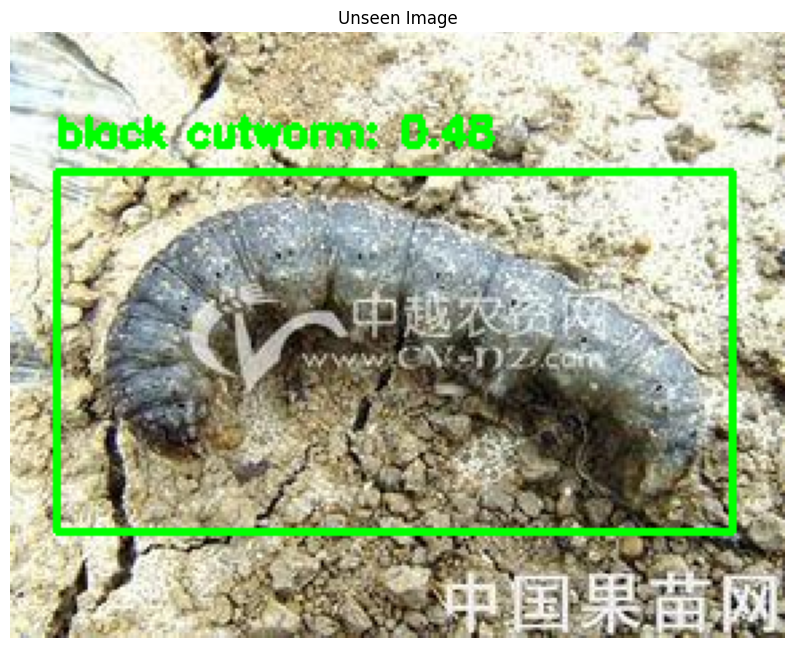


Detection Results (Confidence Threshold 0.1):
Class: black cutworm, Confidence: 0.48, Box: [xmin=18, ymin=52, xmax=270, ymax=186]


In [15]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import yaml

# Step 1: Load the Class Names from ip102.yaml
yaml_path = "/kaggle/working/ip102_corrected.yaml"  # Use the corrected YAML file from previous code
with open(yaml_path, 'r') as f:
    yaml_content = yaml.safe_load(f)
class_names = yaml_content['names']  # List of 102 pest class names
print(f"Loaded {len(class_names)} class names from ip102.yaml")

# Verify the class ID for "black cutworm"
black_cutworm_id = class_names.index('black cutworm')
print(f"Class 'black cutworm' has ID: {black_cutworm_id}")

# Step 2: Load the Trained YOLOv11 Model
# Path to the best weights from the training output
model_weights_path = "/kaggle/working/yolo11_training/ip102_exp3/weights/best.pt"  # Updated to match your output
model = YOLO(model_weights_path)
print(f"Loaded trained YOLOv11 model from {model_weights_path}")

# Step 3: Load the Unseen Image
# Use the image you mentioned, which is supposed to contain a black cutworm
unseen_image_path = "/kaggle/input/pest-test-images/black cutworm_12184.jpg"  # Image that failed to detect
img = cv2.imread(unseen_image_path)
if img is None:
    raise FileNotFoundError(f"Could not load image from {unseen_image_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for visualization
img_height, img_width = img.shape[:2]
print(f"Image dimensions: {img_width}x{img_height}")

# Step 4: Perform Inference with a Lower Confidence Threshold
# Run inference with a lower confidence threshold and verbose output for debugging
results = model.predict(
    source=unseen_image_path,
    conf=0.1,  # Lowered confidence threshold to 0.1 to capture more detections
    iou=0.7,   # IoU threshold for NMS
    imgsz=416, # Image size used during training
    device=0,  # Use GPU
    verbose=True  # Keep verbose output for debugging
)

# Step 5: Process and Visualize the Results
# Get the first result (since we're predicting on a single image)
result = results[0]

# Extract bounding boxes, class IDs, and confidence scores
boxes = result.boxes.xyxy.cpu().numpy() if result.boxes else np.array([])  # Bounding boxes in [xmin, ymin, xmax, ymax]
confidences = result.boxes.conf.cpu().numpy() if result.boxes else np.array([])  # Confidence scores
class_ids = result.boxes.cls.cpu().numpy().astype(int) if result.boxes else np.array([])  # Class IDs

# Debug: Check raw detections (even below the confidence threshold)
# Ultralytics applies the confidence threshold internally, but we can access raw predictions if needed
print("\nRaw Detections (before confidence thresholding):")
raw_results = model.predict(
    source=unseen_image_path,
    conf=0.01,  # Very low threshold to see all potential detections
    iou=0.7,
    imgsz=416,
    device=0,
    verbose=False
)
raw_result = raw_results[0]
raw_boxes = raw_result.boxes.xyxy.cpu().numpy() if raw_result.boxes else np.array([])
raw_confidences = raw_result.boxes.conf.cpu().numpy() if raw_result.boxes else np.array([])
raw_class_ids = raw_result.boxes.cls.cpu().numpy().astype(int) if raw_result.boxes else np.array([])
if len(raw_boxes) > 0:
    for box, conf, class_id in zip(raw_boxes, raw_confidences, raw_class_ids):
        print(f"Class: {class_names[class_id]}, Confidence: {conf:.4f}, Box: [xmin={box[0]:.0f}, ymin={box[1]:.0f}, xmax={box[2]:.0f}, ymax={box[3]:.0f}]")
else:
    print("No raw detections found even with a very low confidence threshold (0.01).")

# Draw bounding boxes and labels on the image if there are detections
if len(boxes) > 0:
    for box, conf, class_id in zip(boxes, confidences, class_ids):
        xmin, ymin, xmax, ymax = map(int, box)
        label = class_names[class_id]
        confidence = conf

        # Draw the bounding box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Create the label with class name and confidence score
        label_text = f"{label}: {confidence:.2f}"
        cv2.putText(
            img,
            label_text,
            (xmin, ymin - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            2
        )
else:
    print("No detections made with confidence threshold 0.1.")

# Step 6: Display the Image (with or without bounding boxes)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Unseen Image")
plt.show()

# Step 7: Print the Detection Results
print("\nDetection Results (Confidence Threshold 0.1):")
if len(boxes) > 0:
    for box, conf, class_id in zip(boxes, confidences, class_ids):
        print(f"Class: {class_names[class_id]}, Confidence: {conf:.2f}, Box: [xmin={box[0]:.0f}, ymin={box[1]:.0f}, xmax={box[2]:.0f}, ymax={box[3]:.0f}]")
else:
    print("No detections found. The image may not contain a detectable pest, or the model may need further training for better generalization.")
    print("Suggestions:")
    print("- Lower the confidence threshold further (e.g., conf=0.05) to see if any detections appear.")
    print("- Verify that the image clearly shows a black cutworm and matches the training data distribution.")
    print("- Check if the model was trained sufficiently on the 'black cutworm' class (class ID 18).")

Loaded 102 class names from ip102.yaml
Class 'black cutworm' has ID: 18
Loaded trained YOLOv11 model from /kaggle/working/yolo11_training/ip102_exp3/weights/best.pt
Image dimensions: 500x374

image 1/1 /kaggle/input/pest-test-images/Miridae_55971.jpg: 320x416 (no detections), 43.5ms
Speed: 1.1ms preprocess, 43.5ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 416)

Raw Detections (before confidence thresholding):
Class: tarnished plant bug, Confidence: 0.0620, Box: [xmin=22, ymin=27, xmax=434, ymax=356]
Class: Miridae, Confidence: 0.0500, Box: [xmin=9, ymin=0, xmax=496, ymax=370]
Class: large cutworm, Confidence: 0.0150, Box: [xmin=33, ymin=2, xmax=499, ymax=369]
Class: Prodenia litura, Confidence: 0.0111, Box: [xmin=31, ymin=0, xmax=463, ymax=373]
Class: black cutworm, Confidence: 0.0111, Box: [xmin=38, ymin=1, xmax=444, ymax=371]
No detections made with confidence threshold 0.1.


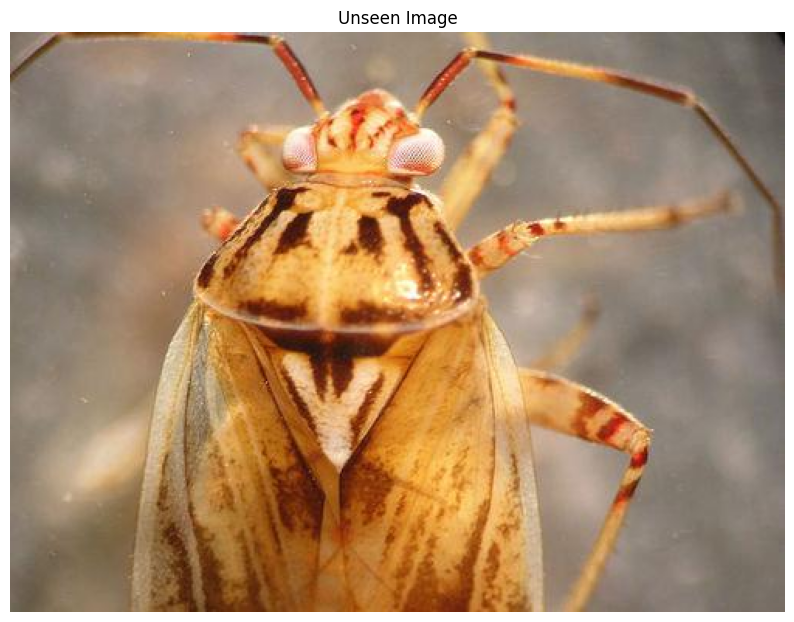


Detection Results (Confidence Threshold 0.1):
No detections found. The image may not contain a detectable pest, or the model may need further training for better generalization.
Suggestions:
- Lower the confidence threshold further (e.g., conf=0.05) to see if any detections appear.
- Verify that the image clearly shows a black cutworm and matches the training data distribution.
- Check if the model was trained sufficiently on the 'black cutworm' class (class ID 18).


In [16]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import yaml

# Step 1: Load the Class Names from ip102.yaml
yaml_path = "/kaggle/working/ip102_corrected.yaml"  # Use the corrected YAML file from previous code
with open(yaml_path, 'r') as f:
    yaml_content = yaml.safe_load(f)
class_names = yaml_content['names']  # List of 102 pest class names
print(f"Loaded {len(class_names)} class names from ip102.yaml")

# Verify the class ID for "black cutworm"
black_cutworm_id = class_names.index('black cutworm')
print(f"Class 'black cutworm' has ID: {black_cutworm_id}")

# Step 2: Load the Trained YOLOv11 Model
# Path to the best weights from the training output
model_weights_path = "/kaggle/working/yolo11_training/ip102_exp3/weights/best.pt"  # Updated to match your output
model = YOLO(model_weights_path)
print(f"Loaded trained YOLOv11 model from {model_weights_path}")

# Step 3: Load the Unseen Image
unseen_image_path = "/kaggle/input/pest-test-images/Miridae_55971.jpg"  # Image that failed to detect
img = cv2.imread(unseen_image_path)
if img is None:
    raise FileNotFoundError(f"Could not load image from {unseen_image_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for visualization
img_height, img_width = img.shape[:2]
print(f"Image dimensions: {img_width}x{img_height}")

# Step 4: Perform Inference with a Lower Confidence Threshold
# Run inference with a lower confidence threshold and verbose output for debugging
results = model.predict(
    source=unseen_image_path,
    conf=0.1,  # Lowered confidence threshold to 0.1 to capture more detections
    iou=0.7,   # IoU threshold for NMS
    imgsz=416, # Image size used during training
    device=0,  # Use GPU
    verbose=True  # Keep verbose output for debugging
)

# Step 5: Process and Visualize the Results
# Get the first result (since we're predicting on a single image)
result = results[0]

# Extract bounding boxes, class IDs, and confidence scores
boxes = result.boxes.xyxy.cpu().numpy() if result.boxes else np.array([])  # Bounding boxes in [xmin, ymin, xmax, ymax]
confidences = result.boxes.conf.cpu().numpy() if result.boxes else np.array([])  # Confidence scores
class_ids = result.boxes.cls.cpu().numpy().astype(int) if result.boxes else np.array([])  # Class IDs

# Debug: Check raw detections (even below the confidence threshold)
# Ultralytics applies the confidence threshold internally, but we can access raw predictions if needed
print("\nRaw Detections (before confidence thresholding):")
raw_results = model.predict(
    source=unseen_image_path,
    conf=0.01,  # Very low threshold to see all potential detections
    iou=0.7,
    imgsz=416,
    device=0,
    verbose=False
)
raw_result = raw_results[0]
raw_boxes = raw_result.boxes.xyxy.cpu().numpy() if raw_result.boxes else np.array([])
raw_confidences = raw_result.boxes.conf.cpu().numpy() if raw_result.boxes else np.array([])
raw_class_ids = raw_result.boxes.cls.cpu().numpy().astype(int) if raw_result.boxes else np.array([])
if len(raw_boxes) > 0:
    for box, conf, class_id in zip(raw_boxes, raw_confidences, raw_class_ids):
        print(f"Class: {class_names[class_id]}, Confidence: {conf:.4f}, Box: [xmin={box[0]:.0f}, ymin={box[1]:.0f}, xmax={box[2]:.0f}, ymax={box[3]:.0f}]")
else:
    print("No raw detections found even with a very low confidence threshold (0.01).")

# Draw bounding boxes and labels on the image if there are detections
if len(boxes) > 0:
    for box, conf, class_id in zip(boxes, confidences, class_ids):
        xmin, ymin, xmax, ymax = map(int, box)
        label = class_names[class_id]
        confidence = conf

        # Draw the bounding box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Create the label with class name and confidence score
        label_text = f"{label}: {confidence:.2f}"
        cv2.putText(
            img,
            label_text,
            (xmin, ymin - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            2
        )
else:
    print("No detections made with confidence threshold 0.1.")

# Step 6: Display the Image (with or without bounding boxes)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Unseen Image")
plt.show()

# Step 7: Print the Detection Results
print("\nDetection Results (Confidence Threshold 0.1):")
if len(boxes) > 0:
    for box, conf, class_id in zip(boxes, confidences, class_ids):
        print(f"Class: {class_names[class_id]}, Confidence: {conf:.2f}, Box: [xmin={box[0]:.0f}, ymin={box[1]:.0f}, xmax={box[2]:.0f}, ymax={box[3]:.0f}]")
else:
    print("No detections found. The image may not contain a detectable pest, or the model may need further training for better generalization.")
    print("Suggestions:")
    print("- Lower the confidence threshold further (e.g., conf=0.05) to see if any detections appear.")
    print("- Verify that the image clearly shows a black cutworm and matches the training data distribution.")
    print("- Check if the model was trained sufficiently on the 'black cutworm' class (class ID 18).")

Loaded 102 class names from ip102.yaml
Class 'black cutworm' has ID: 18
Loaded trained YOLOv11 model from /kaggle/working/yolo11_training/ip102_exp3/weights/best.pt
Image dimensions: 539x352

image 1/1 /kaggle/input/pest-test-images/alfalfa weevil_30721.jpg: 288x416 1 wireworm, 1 beet weevil, 47.7ms
Speed: 1.0ms preprocess, 47.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)

Raw Detections (before confidence thresholding):
Class: beet weevil, Confidence: 0.1247, Box: [xmin=37, ymin=86, xmax=450, ymax=304]
Class: wireworm, Confidence: 0.1110, Box: [xmin=34, ymin=81, xmax=470, ymax=321]
Class: rice water weevil, Confidence: 0.0919, Box: [xmin=33, ymin=84, xmax=465, ymax=322]
Class: Pieris canidia, Confidence: 0.0132, Box: [xmin=45, ymin=92, xmax=445, ymax=305]
Class: lytta polita, Confidence: 0.0108, Box: [xmin=25, ymin=78, xmax=479, ymax=329]


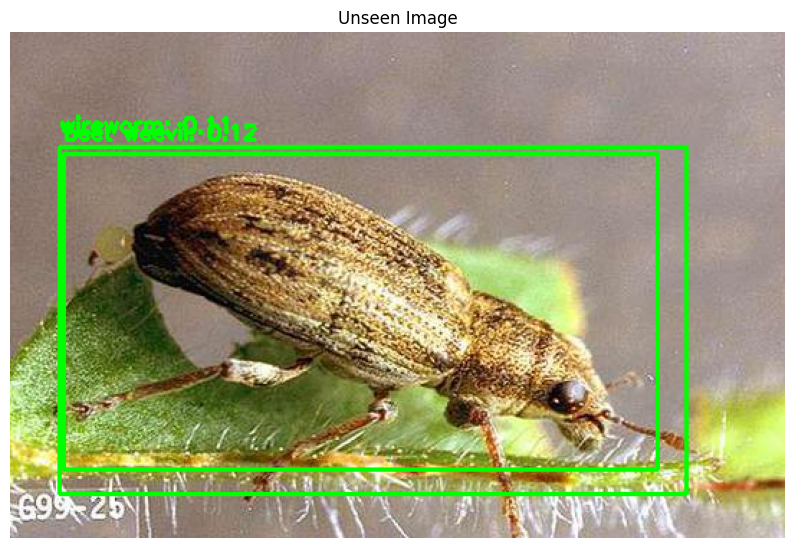


Detection Results (Confidence Threshold 0.1):
Class: beet weevil, Confidence: 0.12, Box: [xmin=37, ymin=86, xmax=450, ymax=304]
Class: wireworm, Confidence: 0.11, Box: [xmin=34, ymin=81, xmax=470, ymax=321]


In [17]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import yaml

# Step 1: Load the Class Names from ip102.yaml
yaml_path = "/kaggle/working/ip102_corrected.yaml"  # Use the corrected YAML file from previous code
with open(yaml_path, 'r') as f:
    yaml_content = yaml.safe_load(f)
class_names = yaml_content['names']  # List of 102 pest class names
print(f"Loaded {len(class_names)} class names from ip102.yaml")

# Verify the class ID for "black cutworm"
black_cutworm_id = class_names.index('black cutworm')
print(f"Class 'black cutworm' has ID: {black_cutworm_id}")

# Step 2: Load the Trained YOLOv11 Model
# Path to the best weights from the training output
model_weights_path = "/kaggle/working/yolo11_training/ip102_exp3/weights/best.pt"  # Updated to match your output
model = YOLO(model_weights_path)
print(f"Loaded trained YOLOv11 model from {model_weights_path}")

# Step 3: Load the Unseen Image
unseen_image_path = "/kaggle/input/pest-test-images/alfalfa weevil_30721.jpg"  # Image that failed to detect
img = cv2.imread(unseen_image_path)
if img is None:
    raise FileNotFoundError(f"Could not load image from {unseen_image_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for visualization
img_height, img_width = img.shape[:2]
print(f"Image dimensions: {img_width}x{img_height}")

# Step 4: Perform Inference with a Lower Confidence Threshold
# Run inference with a lower confidence threshold and verbose output for debugging
results = model.predict(
    source=unseen_image_path,
    conf=0.1,  # Lowered confidence threshold to 0.1 to capture more detections
    iou=0.7,   # IoU threshold for NMS
    imgsz=416, # Image size used during training
    device=0,  # Use GPU
    verbose=True  # Keep verbose output for debugging
)

# Step 5: Process and Visualize the Results
# Get the first result (since we're predicting on a single image)
result = results[0]

# Extract bounding boxes, class IDs, and confidence scores
boxes = result.boxes.xyxy.cpu().numpy() if result.boxes else np.array([])  # Bounding boxes in [xmin, ymin, xmax, ymax]
confidences = result.boxes.conf.cpu().numpy() if result.boxes else np.array([])  # Confidence scores
class_ids = result.boxes.cls.cpu().numpy().astype(int) if result.boxes else np.array([])  # Class IDs

# Debug: Check raw detections (even below the confidence threshold)
# Ultralytics applies the confidence threshold internally, but we can access raw predictions if needed
print("\nRaw Detections (before confidence thresholding):")
raw_results = model.predict(
    source=unseen_image_path,
    conf=0.01,  # Very low threshold to see all potential detections
    iou=0.7,
    imgsz=416,
    device=0,
    verbose=False
)
raw_result = raw_results[0]
raw_boxes = raw_result.boxes.xyxy.cpu().numpy() if raw_result.boxes else np.array([])
raw_confidences = raw_result.boxes.conf.cpu().numpy() if raw_result.boxes else np.array([])
raw_class_ids = raw_result.boxes.cls.cpu().numpy().astype(int) if raw_result.boxes else np.array([])
if len(raw_boxes) > 0:
    for box, conf, class_id in zip(raw_boxes, raw_confidences, raw_class_ids):
        print(f"Class: {class_names[class_id]}, Confidence: {conf:.4f}, Box: [xmin={box[0]:.0f}, ymin={box[1]:.0f}, xmax={box[2]:.0f}, ymax={box[3]:.0f}]")
else:
    print("No raw detections found even with a very low confidence threshold (0.01).")

# Draw bounding boxes and labels on the image if there are detections
if len(boxes) > 0:
    for box, conf, class_id in zip(boxes, confidences, class_ids):
        xmin, ymin, xmax, ymax = map(int, box)
        label = class_names[class_id]
        confidence = conf

        # Draw the bounding box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Create the label with class name and confidence score
        label_text = f"{label}: {confidence:.2f}"
        cv2.putText(
            img,
            label_text,
            (xmin, ymin - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            2
        )
else:
    print("No detections made with confidence threshold 0.1.")

# Step 6: Display the Image (with or without bounding boxes)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Unseen Image")
plt.show()

# Step 7: Print the Detection Results
print("\nDetection Results (Confidence Threshold 0.1):")
if len(boxes) > 0:
    for box, conf, class_id in zip(boxes, confidences, class_ids):
        print(f"Class: {class_names[class_id]}, Confidence: {conf:.2f}, Box: [xmin={box[0]:.0f}, ymin={box[1]:.0f}, xmax={box[2]:.0f}, ymax={box[3]:.0f}]")
else:
    print("No detections found. The image may not contain a detectable pest, or the model may need further training for better generalization.")
    print("Suggestions:")
    print("- Lower the confidence threshold further (e.g., conf=0.05) to see if any detections appear.")
    print("- Verify that the image clearly shows a black cutworm and matches the training data distribution.")
    print("- Check if the model was trained sufficiently on the 'black cutworm' class (class ID 18).")

Loaded 102 class names from ip102.yaml
Class 'black cutworm' has ID: 18
Loaded trained YOLOv11 model from /kaggle/working/yolo11_training/ip102_exp3/weights/best.pt
Image dimensions: 500x375

image 1/1 /kaggle/input/pest-test-images/grub_08463.jpg: 320x416 2 grubs, 1 Chrysomphalus aonidum, 9.2ms
Speed: 1.2ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 320, 416)

Raw Detections (before confidence thresholding):
Class: grub, Confidence: 0.1953, Box: [xmin=160, ymin=171, xmax=298, ymax=285]
Class: Chrysomphalus aonidum, Confidence: 0.1243, Box: [xmin=286, ymin=137, xmax=387, ymax=231]
Class: grub, Confidence: 0.1148, Box: [xmin=197, ymin=170, xmax=300, ymax=275]
Class: Chrysomphalus aonidum, Confidence: 0.0975, Box: [xmin=433, ymin=190, xmax=500, ymax=273]
Class: grub, Confidence: 0.0639, Box: [xmin=210, ymin=169, xmax=297, ymax=256]
Class: Chrysomphalus aonidum, Confidence: 0.0550, Box: [xmin=395, ymin=95, xmax=500, ymax=209]
Class: grub, Confidence: 0.0390, 

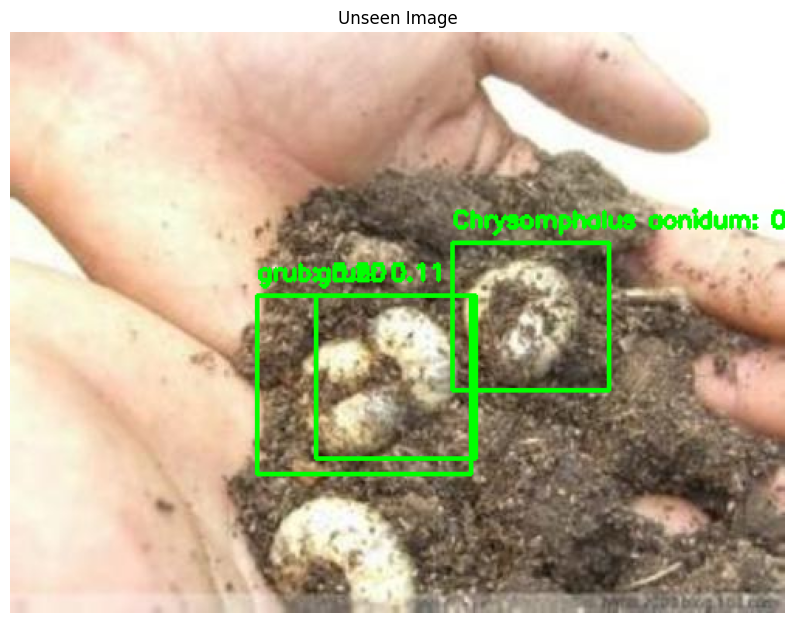


Detection Results (Confidence Threshold 0.1):
Class: grub, Confidence: 0.20, Box: [xmin=160, ymin=171, xmax=298, ymax=285]
Class: Chrysomphalus aonidum, Confidence: 0.12, Box: [xmin=286, ymin=137, xmax=387, ymax=231]
Class: grub, Confidence: 0.11, Box: [xmin=197, ymin=170, xmax=300, ymax=275]


In [18]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import yaml

# Step 1: Load the Class Names from ip102.yaml
yaml_path = "/kaggle/working/ip102_corrected.yaml"  # Use the corrected YAML file from previous code
with open(yaml_path, 'r') as f:
    yaml_content = yaml.safe_load(f)
class_names = yaml_content['names']  # List of 102 pest class names
print(f"Loaded {len(class_names)} class names from ip102.yaml")

# Verify the class ID for "black cutworm"
black_cutworm_id = class_names.index('black cutworm')
print(f"Class 'black cutworm' has ID: {black_cutworm_id}")

# Step 2: Load the Trained YOLOv11 Model
# Path to the best weights from the training output
model_weights_path = "/kaggle/working/yolo11_training/ip102_exp3/weights/best.pt"  # Updated to match your output
model = YOLO(model_weights_path)
print(f"Loaded trained YOLOv11 model from {model_weights_path}")

# Step 3: Load the Unseen Image
unseen_image_path = "/kaggle/input/pest-test-images/grub_08463.jpg"  # Image that failed to detect
img = cv2.imread(unseen_image_path)
if img is None:
    raise FileNotFoundError(f"Could not load image from {unseen_image_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for visualization
img_height, img_width = img.shape[:2]
print(f"Image dimensions: {img_width}x{img_height}")

# Step 4: Perform Inference with a Lower Confidence Threshold
# Run inference with a lower confidence threshold and verbose output for debugging
results = model.predict(
    source=unseen_image_path,
    conf=0.1,  # Lowered confidence threshold to 0.1 to capture more detections
    iou=0.7,   # IoU threshold for NMS
    imgsz=416, # Image size used during training
    device=0,  # Use GPU
    verbose=True  # Keep verbose output for debugging
)

# Step 5: Process and Visualize the Results
# Get the first result (since we're predicting on a single image)
result = results[0]

# Extract bounding boxes, class IDs, and confidence scores
boxes = result.boxes.xyxy.cpu().numpy() if result.boxes else np.array([])  # Bounding boxes in [xmin, ymin, xmax, ymax]
confidences = result.boxes.conf.cpu().numpy() if result.boxes else np.array([])  # Confidence scores
class_ids = result.boxes.cls.cpu().numpy().astype(int) if result.boxes else np.array([])  # Class IDs

# Debug: Check raw detections (even below the confidence threshold)
# Ultralytics applies the confidence threshold internally, but we can access raw predictions if needed
print("\nRaw Detections (before confidence thresholding):")
raw_results = model.predict(
    source=unseen_image_path,
    conf=0.01,  # Very low threshold to see all potential detections
    iou=0.7,
    imgsz=416,
    device=0,
    verbose=False
)
raw_result = raw_results[0]
raw_boxes = raw_result.boxes.xyxy.cpu().numpy() if raw_result.boxes else np.array([])
raw_confidences = raw_result.boxes.conf.cpu().numpy() if raw_result.boxes else np.array([])
raw_class_ids = raw_result.boxes.cls.cpu().numpy().astype(int) if raw_result.boxes else np.array([])
if len(raw_boxes) > 0:
    for box, conf, class_id in zip(raw_boxes, raw_confidences, raw_class_ids):
        print(f"Class: {class_names[class_id]}, Confidence: {conf:.4f}, Box: [xmin={box[0]:.0f}, ymin={box[1]:.0f}, xmax={box[2]:.0f}, ymax={box[3]:.0f}]")
else:
    print("No raw detections found even with a very low confidence threshold (0.01).")

# Draw bounding boxes and labels on the image if there are detections
if len(boxes) > 0:
    for box, conf, class_id in zip(boxes, confidences, class_ids):
        xmin, ymin, xmax, ymax = map(int, box)
        label = class_names[class_id]
        confidence = conf

        # Draw the bounding box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Create the label with class name and confidence score
        label_text = f"{label}: {confidence:.2f}"
        cv2.putText(
            img,
            label_text,
            (xmin, ymin - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            2
        )
else:
    print("No detections made with confidence threshold 0.1.")

# Step 6: Display the Image (with or without bounding boxes)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Unseen Image")
plt.show()

# Step 7: Print the Detection Results
print("\nDetection Results (Confidence Threshold 0.1):")
if len(boxes) > 0:
    for box, conf, class_id in zip(boxes, confidences, class_ids):
        print(f"Class: {class_names[class_id]}, Confidence: {conf:.2f}, Box: [xmin={box[0]:.0f}, ymin={box[1]:.0f}, xmax={box[2]:.0f}, ymax={box[3]:.0f}]")
else:
    print("No detections found. The image may not contain a detectable pest, or the model may need further training for better generalization.")
    print("Suggestions:")
    print("- Lower the confidence threshold further (e.g., conf=0.05) to see if any detections appear.")
    print("- Verify that the image clearly shows a black cutworm and matches the training data distribution.")
    print("- Check if the model was trained sufficiently on the 'black cutworm' class (class ID 18).")

In [ ]:
# Note: To convert ONNX to TensorFlow Lite, you'll need to run the following steps on a local machine with TensorFlow installed.
"""
# Example commands (run locally after downloading the ONNX model):
!pip install onnx onnx-tf tf2onnx
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf

# Load ONNX model
onnx_model = onnx.load("yolo11s.onnx")
tf_rep = prepare(onnx_model)

# Export to TensorFlow
tf_rep.export_graph("yolo11s_tf")

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model("yolo11s_tf")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("yolo11s.tflite", "wb") as f:
    f.write(tflite_model)
"""
print("Model exported to ONNX. Convert to TensorFlow Lite locally for mobile deployment.")